In [1]:
print("Chaliye suru karte hai !!!")

Chaliye suru karte hai !!!


In [4]:
# Installing all the required libraries
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import lime
from lime import lime_image
from keras.applications import inception_v3 as inc_net
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image as keras_image
from skimage.segmentation import mark_boundaries
from matplotlib.patches import Rectangle, Circle
print("Import successfull...")

Import successfull...


In [14]:

# Load the pre-trained face detection model (MTCNN)
detector = MTCNN()

# Function to return bounding boxes
def detect_faces():
    bounding_boxes = [face['box'] for face in result]
    return bounding_boxes

# Load your image using OpenCV
image_path = r"C:\Users\admin\Pictures\katherine-Copy.jpg"
image = cv2.imread(image_path)

result = detector.detect_faces(image)
# Detect faces in the image using the face detection model
bounding_boxes = detect_faces()



1/1 [==============================] - 0s 145ms/step


Visualization of detected face by MTCNN model

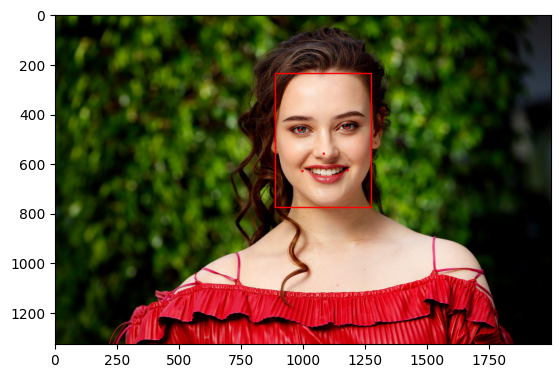

In [19]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)

        # Drawing the dots to identify eye and nose present in images
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = Circle(value, radius=2, color='red')
            ax.add_patch(dot)
    # show the plot
    plt.show()

draw_image_with_boxes(image_path,result)

Defining function for image preprocessing so that it can be used with InceptionV3 model

In [15]:

# Function to crop the image based on bounding boxes
def crop_faces(image, bounding_boxes):
    cropped_faces = []
    for box in bounding_boxes:
        x, y, w, h = box
        face = image[y:y+h, x:x+w]
        cropped_faces.append(face)
    return cropped_faces

# Resize the image to match the expected input size of Inception V3
def resize_image(image):
    return cv2.resize(image, (299, 299))

In [16]:
# Create a standard InceptionV3 pretrained model 
inet_model = inc_net.InceptionV3()
# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 348ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


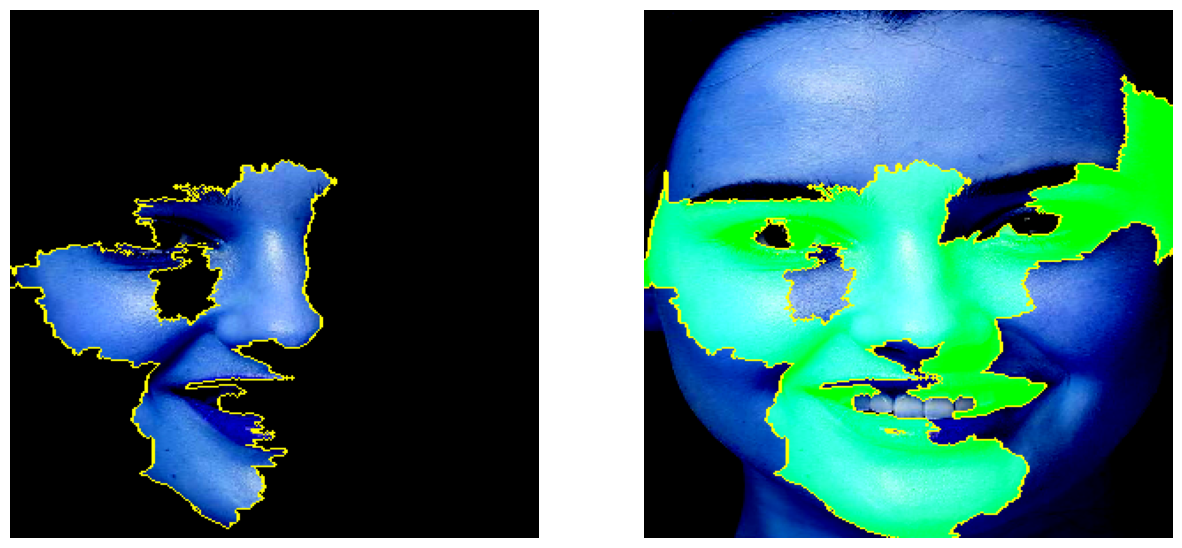

In [17]:

# Create LIME explanation for each detected face
for i, box in enumerate(bounding_boxes):
    x, y, w, h = box
    # Crop the image to focus on the detected face
    cropped_face = crop_faces(image, [box])[0]
    resized_face = resize_image(cropped_face)

    # Preprocess the image to be compatible with the model
    preprocessed_img = preprocess_input(resized_face)
    
    # Generate explanation for the specific face region
    explanation = explainer.explain_instance(
        preprocessed_img,
        inet_model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000,
    )
    
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

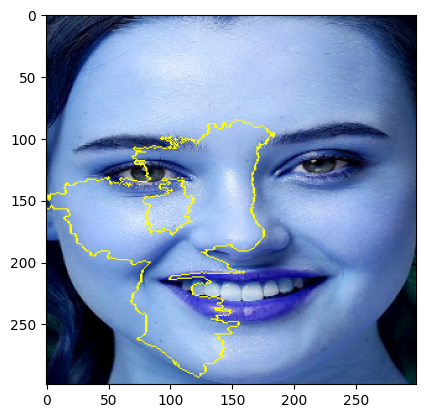

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

To check the performance of the MTCNN (optional)

In [ ]:
# TO calculate performance of MTCNN model intersect of union function can be used function is used ---------
def calculate_iou(boxA, boxB):
    # Calculate the intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Calculate intersection area
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of both boxes
    boxA_area = (boxA[2] + 1) * (boxA[3] + 1)
    boxB_area = (boxB[2] + 1) * (boxB[3] + 1)

    # Calculate IoU
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    return iou

# Assuming ground truth bounding box and predicted bounding box
ground_truth_box = [384, 134, 512, 303]  # Ground truth bounding box coordinates
predicted_box = [382, 143, 508, 305]  # Predicted bounding box coordinates

iou = calculate_iou(ground_truth_box, predicted_box)
print(f"IoU: {iou}")
# Priyanshu jha: IoU: 0.9487376272536444
# Jawed Hawari : IoU: 0.9224378781430976